# Estimation of basal enzymes concentrations in failings hearts from Copeland et al. 2010 data (https://doi.org/10.1016/j.yjmcc.2010.09.007)

This notebook performs the paramter estimation procedure for the results shown in Figure 4A,B and Figures S22 of the publication:

Thomas Kampourakis, Saraswathi Ponnam, Daniel Koch (2023):
The cardiac myosin binding protein-C phosphorylation state as a function of multiple protein kinase and phosphatase activities 
Preprint available under: https://doi.org/10.1101/2023.02.24.529959 

Note that the files '**cMyBPC_FinalModelCopelandHF.cps**'' and '**copeland2010_HF.csv**' are required to be in the same folder as this notebook,
that the file '**fittedEnzymeConcentrations_Copeland_DonorHearts.npy**' needs to be in the subfolder '**\results**' relative to this file
and that the file '**\parametersets\paramset_final.npy** needs to be in the parent folder. 

The final figures in the paper are generated by the script '**data_analysis_Copeland_and_optimization.py**'.

### **Step 0**: load packages, define boundaries and initial guesses for parameter estimates, define settings for parameter estimation algorithms.

In [19]:
from basico import *
import sys
%pylab
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
if not '../..' in sys.path:
    sys.path.append('../..')
    
import os
fileDirectory = os.path.abspath('')
path_paramsets = os.path.join(os.path.split(fileDirectory)[0], 'parametersets') 
path_results = os.path.join(fileDirectory, 'results') 

# Load fitted parametersets for PKA, PP1, PP2A
paramset = np.load(os.path.join(path_paramsets, 'paramset_final_tQSSA.npy'))
    
load_model('cMyBPC_FinalModel_tQSSA_CopelandHF.cps')

# Add measured PKC params
pkc_Kms = np.linspace(3.167e-6,	7.537e-6,4)
pkc_kcat = (5.053+5.262)/2
paramset[:,42] = pkc_Kms[0]
paramset[:,45] = pkc_Kms[1]
paramset[:,48] = pkc_Kms[2]
paramset[:,51] = pkc_Kms[3]
paramset[:,[12,15,18,21]] = pkc_kcat

print(get_parameters())

cMyBPC_tot = 2e-5 #2e-5, 2e-6, 2e-7
set_species('0P', initial_concentration=cMyBPC_tot)

donorValues = np.mean(np.load(os.path.join(path_results,'fittedEnzymeConcentrations_Copeland_DonorHearts_tQSSA_'+str(np.format_float_scientific(cMyBPC_tot, unique=False, precision=2))+'.npy'))[:,2:],axis=0) 

f2 = 2

low_up_bnd = [[5e-10, 5e-7],  #PKA
              [0,2e-7],      #PKC
              [1e-10,f2*donorValues[3]],  #PP1
              [f2*donorValues[3],f2*donorValues[3]],   #total Phosphatases
              [0,2e-7]       #RSK2
             ]
startVal =   [1e-9, 1e-8, 1e-6, 2e-6, 1e-8] #PKA, PKC, PP1, total Phosphatases, RSK2 

#Settings for parameter estimation algorithms
settingsHJ = {'method': {'name': PE.HOOKE_JEEVES, 'Iteration Limit':50,'Tolerance':1e-05, 'Rho':0.2}}

Using matplotlib backend: QtAgg
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


F:\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['exp']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


                  type unit  initial_value initial_expression  \
name                                                            
TOT         assignment        2.000000e-05                      
3P_rel      assignment        0.000000e+00                      
A_rel       assignment        0.000000e+00                      
AB_rel      assignment        0.000000e+00                      
ABC_rel     assignment        0.000000e+00                      
...                ...  ...            ...                ...   
ABX_rel     assignment        0.000000e+00                      
ABCX_rel    assignment        0.000000e+00                      
PPase_tot        fixed        1.000000e-07                      
quantity         fixed        2.000000e-06                      
Kappa_RSK2  assignment        1.537279e+01                      

                                                   expression  value  rate  \
name                                                                        

In [20]:
# Parameter names in Copasi model which are not to be estimated
paramNames = []
for i in range(1,31):
    paramNames.append('k'+str(i))
for i in range(1,31):
    paramNames.append('K'+str(i))
    
p_app = ['k2f','K2f','kisoF','kisoR','k3f','K3f']
for s in p_app: paramNames.append(s)

print(paramNames)

['k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8', 'k9', 'k10', 'k11', 'k12', 'k13', 'k14', 'k15', 'k16', 'k17', 'k18', 'k19', 'k20', 'k21', 'k22', 'k23', 'k24', 'k25', 'k26', 'k27', 'k28', 'k29', 'k30', 'K1', 'K2', 'K3', 'K4', 'K5', 'K6', 'K7', 'K8', 'K9', 'K10', 'K11', 'K12', 'K13', 'K14', 'K15', 'K16', 'K17', 'K18', 'K19', 'K20', 'K21', 'K22', 'K23', 'K24', 'K25', 'K26', 'K27', 'K28', 'K29', 'K30', 'k2f', 'K2f', 'kisoF', 'kisoR', 'k3f', 'K3f']


### **Step 1**: define which parameters to estimate and range for estimates etc

In [21]:
#Defining which parameters to estimate and setting boundaries and start values
vNames_cps = [
             'Values[PKA].InitialValue',
             'Values[PKC].InitialValue',
             'Values[PP1].InitialValue',
             'Values[PPase_tot].InitialValue',
             'Values[RSK2].InitialValue',]

fit_items = []
for i in range(len(vNames_cps)):
    fit_items.append({'name': vNames_cps[i], 'lower': low_up_bnd[i][0], 'upper': low_up_bnd[i][1], 'start': startVal[i]})


set_fit_parameters(fit_items)

#Show settings for fitting parameters
get_fit_parameters()

,lower,upper,start,affected,cn
name,,,,,
Values[PKA],5e-10,5e-07,1.000000e-09,[],"CN=Root,Model=New Model,Vector=Values[PKA],Ref..."
Values[PKC],0.0,2e-07,1.000000e-08,[],"CN=Root,Model=New Model,Vector=Values[PKC],Ref..."
Values[PP1],1e-10,5.19084435032662e-07,1.000000e-06,[],"CN=Root,Model=New Model,Vector=Values[PP1],Ref..."
Values[PPase_tot],5.19084435032662e-07,5.19084435032662e-07,2.000000e-06,[],"CN=Root,Model=New Model,Vector=Values[PPase_to..."
Values[RSK2],0.0,2e-07,1.000000e-08,[],"CN=Root,Model=New Model,Vector=Values[RSK2],Re..."


### **Step 2**: local search using Hooke & Jeeves algorithm

In [22]:
from tqdm import tqdm

result = np.array([])
fitValsHF = np.array([])

nruns = paramset.shape[0] # number of parameter runs to be performed

#set RSK2 params (same for all paramsets)
set_parameters(name= 'k31', initial_value = 1.8, value = 1.8)
set_parameters(name= 'k32', initial_value = 1.8, value = 1.8)
set_parameters(name= 'K31', initial_value = 1.3e-6, value = 1.3e-6)
set_parameters(name= 'K32', initial_value = 1.3e-6, value = 1.3e-6)

for i in tqdm(range(0,nruns)):
    
    #set other parameters fitted previously
    for pn in range(len(paramNames)):
                set_parameters(name= paramNames[pn], initial_value = paramset[i,2+pn], value = paramset[i,2+pn])
    
    # fit enzyme concentrations (PKA, PKC, etc...)
    n = 0
    while n < 5:
        try:
            currentParams = run_parameter_estimation(settings=settingsHJ, update_model=True)
            estimates = np.array(currentParams['sol']) # estimates for parameters
            stats = get_fit_statistic(solution=currentParams)
            exp, sim = get_simulation_results(solution=currentParams)
            objFval = np.array(stats['obj']) # value of the objective function
            
            # Fill the result matrix:
            # if first run, generate horizontal array with run nr., objFunc value and resulting parameters to fill first row
            # if i-th run, perform vertical concatenation to fill i-th row
            if len(result) > 0: 
                result = np.vstack((result, np.hstack((np.array([i]), objFval, estimates))))
                fitValsHF = np.vstack((fitValsHF, np.asarray(sim[0])))
            else:
                result = np.hstack((np.array([i]), objFval, estimates))
                fitValsHF = np.asarray(sim[0])
            n=5
            
        except:
            print('numerical error - trying again...')
            n = n + 1

np.save('fittedEnzymeConcentrations_Copeland_FailingHearts_tQSSA_'+str(np.format_float_scientific(cMyBPC_tot, unique=False, precision=2))+'.npy',result)  
np.save('fittedMyBPCstates_Copeland_FailingHearts_tQSSA_'+str(np.format_float_scientific(cMyBPC_tot, unique=False, precision=2))+'.npy',fitValsHF)

100%|██████████| 18/18 [00:40<00:00,  2.26s/it]


## plot data

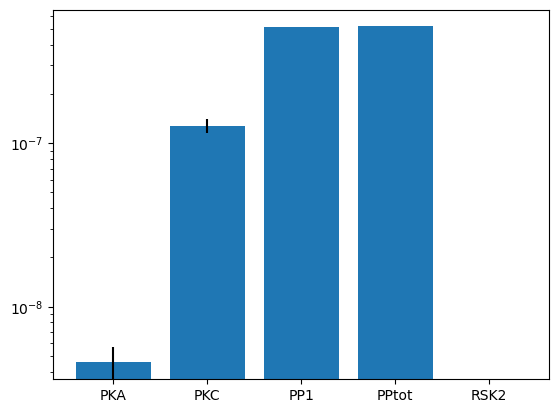

(-0.05, 1.05)

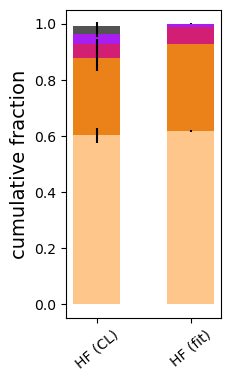

In [23]:
import matplotlib.pyplot as plt


means_HF_fit = np.mean(fitValsHF,axis=0)
SEMs_HF_fit = np.std(fitValsHF,axis=0)/np.sqrt(nruns)

plt.bar(np.asarray(range(5)), np.mean(result[:,2:],axis=0),yerr=np.std(result[:,2:],axis=0)/np.sqrt(nruns))
plt.yscale('log')
plt.xticks(np.asarray(range(5)),['PKA','PKC','PP1','PPtot','RSK2'])
plt.show()

####### Experimental data from Copeland et al. 2010  ###########      
nsamples_HF = 19
means_HF = np.array([0.601,0.278,0.048,0.037,0.028])
SEMs_HF = np.array([0.028,0.048,0.02,0.012,0.013])
SDs_HF = SEMs_HF*np.sqrt(nsamples_HF)
###############################################################
 
c4P_2 =  (0.25,0.25,0.25) 
c3P =  (159/255, 5/255, 240/255) 
c2P =  (206/255, 6/255, 101/255) 
c1P =  (232/255, 116/255, 0/255) 
c0P =  (255/255, 192/255, 128/255) 
colors = [c0P,c1P,c2P,c3P,c4P_2]
pstates = ['0P','1P','2P','3P','4P']
width = 0.5
fig, ax = plt.subplots(figsize=(2,4))

btm_HF = 0
btm_HF_fit = 0

for i in range(5):
    ax.bar(1, means_HF[i], width, yerr=SEMs_HF[i], bottom=btm_HF,color = colors[i],alpha=0.9)
    ax.bar(2, means_HF_fit[i], width, yerr=SEMs_HF_fit[i], bottom=btm_HF_fit,color = colors[i],alpha=0.9)
    btm_HF = btm_HF + means_HF[i]
    btm_HF_fit = btm_HF_fit + means_HF_fit[i]
        
ax.set_xticks([1,2])
ax.set_xticklabels(['HF (CL)','HF (fit)'],rotation=40)
ax.set_ylabel('cumulative fraction',fontsize=14)
ax.set_ylim(-0.05,1.05)


In [24]:
print('average of fitted enzyme concentrations to HF data:')
enzymeNames = ['PKA','PKC','PP1','PPtot','RSK2']
for i in range(5):
    print(enzymeNames[i],': ', np.mean(result[:,2+i],axis=0))
print('PKA/PPtot:',np.mean(result[:,0+2])/np.mean(result[:,3+2]))


average of fitted enzyme concentrations to HF data:
PKA :  4.550429019859728e-09
PKC :  1.2811877925943802e-07
PP1 :  5.160849113924305e-07
PPtot :  5.19084435032662e-07
RSK2 :  0.0
PKA/PPtot: 0.008766259808143552


## Control experiment: fitting failing heart data with PP2A only

### **Step 1**: define which parameters to estimate and range for estimates etc

In [25]:
f2 = 2

low_up_bnd = [[5e-10, 5e-7],  #PKA
              [0,2e-7],      #PKC
              [0,0],  #PP1
              [f2*donorValues[3],f2*donorValues[3]],   #total Phosphatases
              [0,2e-7]       #RSK2
             ]
startVal =   [1e-9, 1e-8, 0, 2e-6, 1e-8] #PKA, PKC, PP1, total Phosphatases, RSK2 

fit_items = []
for i in range(len(vNames_cps)):
    fit_items.append({'name': vNames_cps[i], 'lower': low_up_bnd[i][0], 'upper': low_up_bnd[i][1], 'start': startVal[i]})


set_fit_parameters(fit_items)

#Show settings for fitting parameters
get_fit_parameters()

,lower,upper,start,affected,cn
name,,,,,
Values[PKA],5e-10,5e-07,1.000000e-09,[],"CN=Root,Model=New Model,Vector=Values[PKA],Ref..."
Values[PKC],0.0,2e-07,1.000000e-08,[],"CN=Root,Model=New Model,Vector=Values[PKC],Ref..."
Values[PP1],0.0,0.0,0.000000e+00,[],"CN=Root,Model=New Model,Vector=Values[PP1],Ref..."
Values[PPase_tot],5.19084435032662e-07,5.19084435032662e-07,2.000000e-06,[],"CN=Root,Model=New Model,Vector=Values[PPase_to..."
Values[RSK2],0.0,2e-07,1.000000e-08,[],"CN=Root,Model=New Model,Vector=Values[RSK2],Re..."


### Step 2: local search using Hooke & Jeeves algorithm

In [26]:
from tqdm import tqdm

result = np.array([])
fitValsHF = np.array([])

nruns = paramset.shape[0] # number of parameter runs to be performed

#set RSK2 params (same for all paramsets)
set_parameters(name= 'k31', initial_value = 1.8, value = 1.8)
set_parameters(name= 'k32', initial_value = 1.8, value = 1.8)
set_parameters(name= 'K31', initial_value = 1.3e-6, value = 1.3e-6)
set_parameters(name= 'K32', initial_value = 1.3e-6, value = 1.3e-6)

for i in tqdm(range(0,nruns)):
    
    #set other parameters fitted previously
    for pn in range(len(paramNames)):
                set_parameters(name= paramNames[pn], initial_value = paramset[i,2+pn], value = paramset[i,2+pn])
    
    # fit enzyme concentrations (PKA, PKC, etc...)
    n = 0
    while n < 5:
        try:
            currentParams = run_parameter_estimation(settings=settingsHJ, update_model=True)
            estimates = np.array(currentParams['sol']) # estimates for parameters
            stats = get_fit_statistic(solution=currentParams)
            exp, sim = get_simulation_results(solution=currentParams)
            objFval = np.array(stats['obj']) # value of the objective function
            
            # Fill the result matrix:
            # if first run, generate horizontal array with run nr., objFunc value and resulting parameters to fill first row
            # if i-th run, perform vertical concatenation to fill i-th row
            if len(result) > 0: 
                result = np.vstack((result, np.hstack((np.array([i]), objFval, estimates))))
                fitValsHF = np.vstack((fitValsHF, np.asarray(sim[0])))
            else:
                result = np.hstack((np.array([i]), objFval, estimates))
                fitValsHF = np.asarray(sim[0])
            n=5
            
        except:
            print('numerical error - trying again...')
            n = n + 1

np.save('fittedMyBPCstates_Copeland_FailingHearts_ctrl_tQSSA_'+str(np.format_float_scientific(cMyBPC_tot, unique=False, precision=2))+'.npy',fitValsHF)  

100%|██████████| 18/18 [01:07<00:00,  3.74s/it]


## plot data

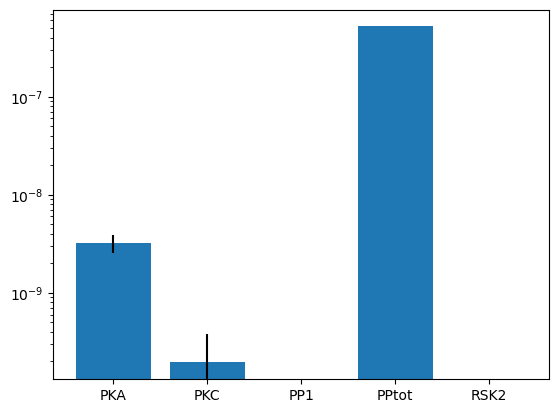

(-0.05, 1.05)

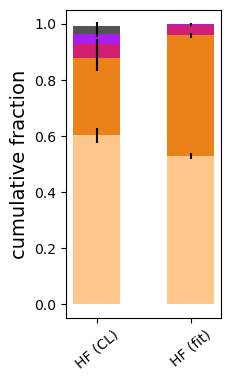

In [27]:
import matplotlib.pyplot as plt


means_HF_fit = np.mean(fitValsHF,axis=0)
SEMs_HF_fit = np.std(fitValsHF,axis=0)/np.sqrt(nruns)

plt.bar(np.asarray(range(5)), np.mean(result[:,2:],axis=0),yerr=np.std(result[:,2:],axis=0)/np.sqrt(nruns))
plt.yscale('log')
plt.xticks(np.asarray(range(5)),['PKA','PKC','PP1','PPtot','RSK2'])
plt.show()

####### Experimental data from Copeland et al. 2010  ###########      
nsamples_HF = 19
means_HF = np.array([0.601,0.278,0.048,0.037,0.028])
SEMs_HF = np.array([0.028,0.048,0.02,0.012,0.013])
SDs_HF = SEMs_HF*np.sqrt(nsamples_HF)
###############################################################
 
c4P_2 =  (0.25,0.25,0.25) 
c3P =  (159/255, 5/255, 240/255) 
c2P =  (206/255, 6/255, 101/255) 
c1P =  (232/255, 116/255, 0/255) 
c0P =  (255/255, 192/255, 128/255) 
colors = [c0P,c1P,c2P,c3P,c4P_2]
pstates = ['0P','1P','2P','3P','4P']
width = 0.5
fig, ax = plt.subplots(figsize=(2,4))

btm_HF = 0
btm_HF_fit = 0

for i in range(5):
    ax.bar(1, means_HF[i], width, yerr=SEMs_HF[i], bottom=btm_HF,color = colors[i],alpha=0.9)
    ax.bar(2, means_HF_fit[i], width, yerr=SEMs_HF_fit[i], bottom=btm_HF_fit,color = colors[i],alpha=0.9)
    btm_HF = btm_HF + means_HF[i]
    btm_HF_fit = btm_HF_fit + means_HF_fit[i]
        
ax.set_xticks([1,2])
ax.set_xticklabels(['HF (CL)','HF (fit)'],rotation=40)
ax.set_ylabel('cumulative fraction',fontsize=14)
ax.set_ylim(-0.05,1.05)